In [1]:
import numpy as np
import pandas as pd
from sklearn import compose, model_selection, preprocessing, metrics, neighbors,linear_model, svm, tree, naive_bayes, neighbors, neural_network, ensemble
from catboost import CatBoostClassifier

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [33]:
import matplotlib.pyplot as plt
import yellowbrick as yb

def evaluate(estimator, param_grid):
    print('Given parameters: ', param_grid)
    grid_search = HalvingGridSearchCV(estimator, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('Best params: ', grid_search.best_params_)
    print('Accuracy: ', grid_search.best_score_)
    best = grid_search.best_estimator_
    predict = best.predict(X_test)
    print(metrics.confusion_matrix(y_test, predict))
    print(metrics.classification_report(y_test, predict))
    visualizer = yb.ROCAUC(best,binary=True, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    return grid_search

In [5]:
X = train_df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
y_train = y_train.ravel()

In [6]:
scaler = preprocessing.StandardScaler()
column_transformer = compose.make_column_transformer(
    (scaler, ['Age', 'Fare', 'Cabin number']),
    remainder='passthrough')
X_train = column_transformer.fit_transform(X_train, y_train)
X_test = column_transformer.transform(X_test)

Decision Tree Classifier:

Given parameters:  {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, None], 'min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20, 10000]}
Best params:  {'max_depth': 5, 'min_samples_split': 2}
Accuracy:  0.7731064397731064
[[11868  2360]
 [ 3229  7543]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     14228
           1       0.76      0.70      0.73     10772

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000



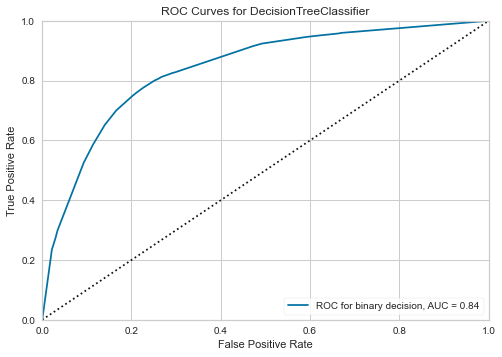

Wall time: 2.04 s


In [42]:
%%time
tree_estimator = tree.DecisionTreeClassifier()
tree_param_grid = dict(max_depth=[3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, None], min_samples_split=[2, 3, 4, 5, 7, 10, 15, 20, 10000])
print('Decision Tree Classifier:\n')
tree_optimal = evaluate(tree_estimator, tree_param_grid)

In [43]:
tree_optimal.fit(X, y)
tree_predict = tree_optimal.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [44]:
submission['Survived'] = tree_predict
submission.to_csv('../data/submission_tree.csv', index=False)

In [50]:
from yellowbrick.contrib.wrapper import wrap

catboost_estimator = wrap(CatBoostClassifier())

In [58]:
%%time
catboost_estimator.fit(X_train, y_train, verbose=0)

Wall time: 19 s


accuracy: 0.77788
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     14228
           1       0.75      0.73      0.74     10772

    accuracy                           0.78     25000
   macro avg       0.77      0.77      0.77     25000
weighted avg       0.78      0.78      0.78     25000

[[11622  2606]
 [ 2947  7825]]


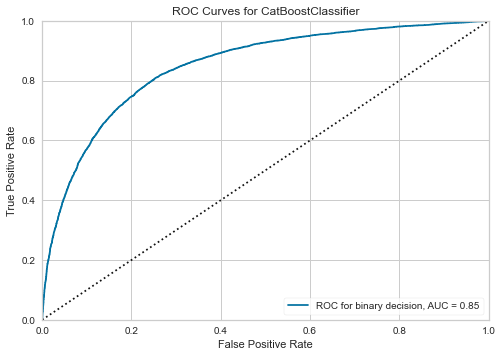

In [59]:
catboost_predict = catboost_estimator.predict(X_test)
print("accuracy:", metrics.accuracy_score(y_test, catboost_predict))
print(metrics.classification_report(y_test, catboost_predict))
print(metrics.confusion_matrix(y_test, catboost_predict))
visualizer = yb.ROCAUC(catboost_estimator, binary=True, classes=[0, 1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [62]:
catboost_estimator.fit(X, y, verbose=0)
catboost_predict = catboost_estimator.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [63]:
submission['Survived'] = catboost_predict
submission.to_csv('../data/submission_catboost.csv', index=False)

Given parameters:  {'min_samples_split': [10, 50, 100, 150, 1000, 10000]}
Best params:  {'min_samples_split': 150}
Accuracy:  0.7763333333333333
[[11628  2600]
 [ 2861  7911]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81     14228
           1       0.75      0.73      0.74     10772

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



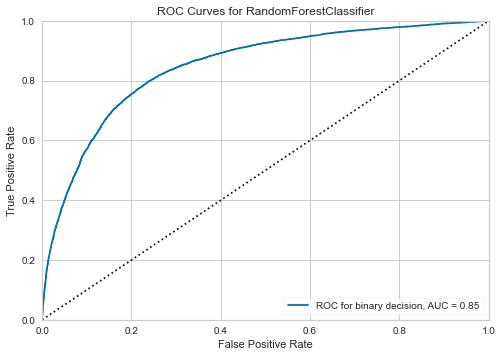

Wall time: 13.9 s


In [61]:
%%time
forest_estimator = ensemble.RandomForestClassifier(bootstrap=True, n_estimators=100, n_jobs=-1)
forest_param_grid = dict(min_samples_split=[10, 50, 100, 150, 1000, 10000])
best_forest = evaluate(forest_estimator, forest_param_grid)

In [64]:
best_forest.fit(X, y)
forest_predict = best_forest.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [65]:
submission['Survived'] = forest_predict
submission.to_csv('../data/submission_forest.csv', index=False)

In [ ]:
%%time
et_estimator = ensemble.ExtraTreesClassifier(n_jobs=-1, bootstrap=True)
knn_param_grid = dict(n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 1000], leaf_size=[20, 30, 50, 100, 1000, 10000])
knn_forest = evaluate(knn_estimator, knn_param_grid)

Given parameters:  {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 1000], 'leaf_size': [20, 30, 50, 100, 1000, 10000]}


In [ ]:
best_forest.fit(X, y)
forest_predict = best_forest.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

In [ ]:
submission['Survived'] = forest_predict
submission.to_csv('../data/submission_forest.csv', index=False)

In [ ]:
%%time
stacking = ensemble.StackingClassifier([('tree', tree_optimal), ('extra trees', best_et), ('catboost', catboost_estimator), ('forest', best_forest)], n_jobs=4)
#stacking.fit(X_train, y_train)

In [28]:
stack_predict = stacking.predict(X_test)
print(metrics.classification_report(y_test, stack_predict))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     14398
           1       0.75      0.73      0.74     10602

    accuracy                           0.78     25000
   macro avg       0.78      0.77      0.78     25000
weighted avg       0.78      0.78      0.78     25000



In [21]:
%%time
stacking.fit(X, y)

Wall time: 17min 16s


StackingClassifier(estimators=[('tree',
                                HalvingGridSearchCV(estimator=DecisionTreeClassifier(),
                                                    n_jobs=-1,
                                                    param_grid={'max_depth': [3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              None],
                                                                'min_samples_leaf': [1,
                                                                                     2,
                                                              

In [22]:
stack_predict = stacking.predict(test_df.drop(columns=['PassengerId','Name', 'Ticket']))

submission['Survived'] = stack_predict
submission.to_csv('../data/submission_stack1.csv', index=False)